In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [4]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format',  '{:.4f}'.format)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None

# Data loading and exploration

In [5]:
# time series data with 10 sec interval

df = pd.read_parquet('data/bms_soc_data.parquet')

In [6]:
df.head()
df.tail()

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8
time,,,,,,,,,,,,,,
2023-11-30 17:40:20+00:00,50.0000,253.3000,3.2579,0.0094,-33.0840,19.5400,3.2594,3.2566,3.2602,3.2524,3.2596,3.2558,3.2586,3.2608
2023-11-30 17:40:30+00:00,50.0000,253.2120,3.2578,0.0094,-33.1240,19.5400,3.2598,3.2568,3.2596,3.2522,3.2596,3.2558,3.2576,3.2612
2023-11-30 17:40:40+00:00,50.0000,253.1200,3.2560,0.0096,-33.2500,19.5000,3.2580,3.2544,3.2578,3.2502,3.2584,3.2534,3.2562,3.2596
2023-11-30 17:40:50+00:00,50.0000,253.0280,3.2591,0.0094,-28.8900,19.5200,3.2610,3.2584,3.2610,3.2532,3.2604,3.2574,3.2592,3.2620
2023-11-30 17:41:00+00:00,50.0000,252.9440,3.2598,0.0090,-28.9320,19.5000,3.2616,3.2588,3.2616,3.2544,3.2614,3.2580,3.2600,3.2628


In [161]:
# Attempt to calculate SOC as accurate as we can
# the internal current sensor is not accurate and has different error on charge and discharge
# we need to detect voltage peaks and reset SOC to 100%
# it's a moment when we have average voltage at 3.43 and then drop below 3.37 (reset condition)

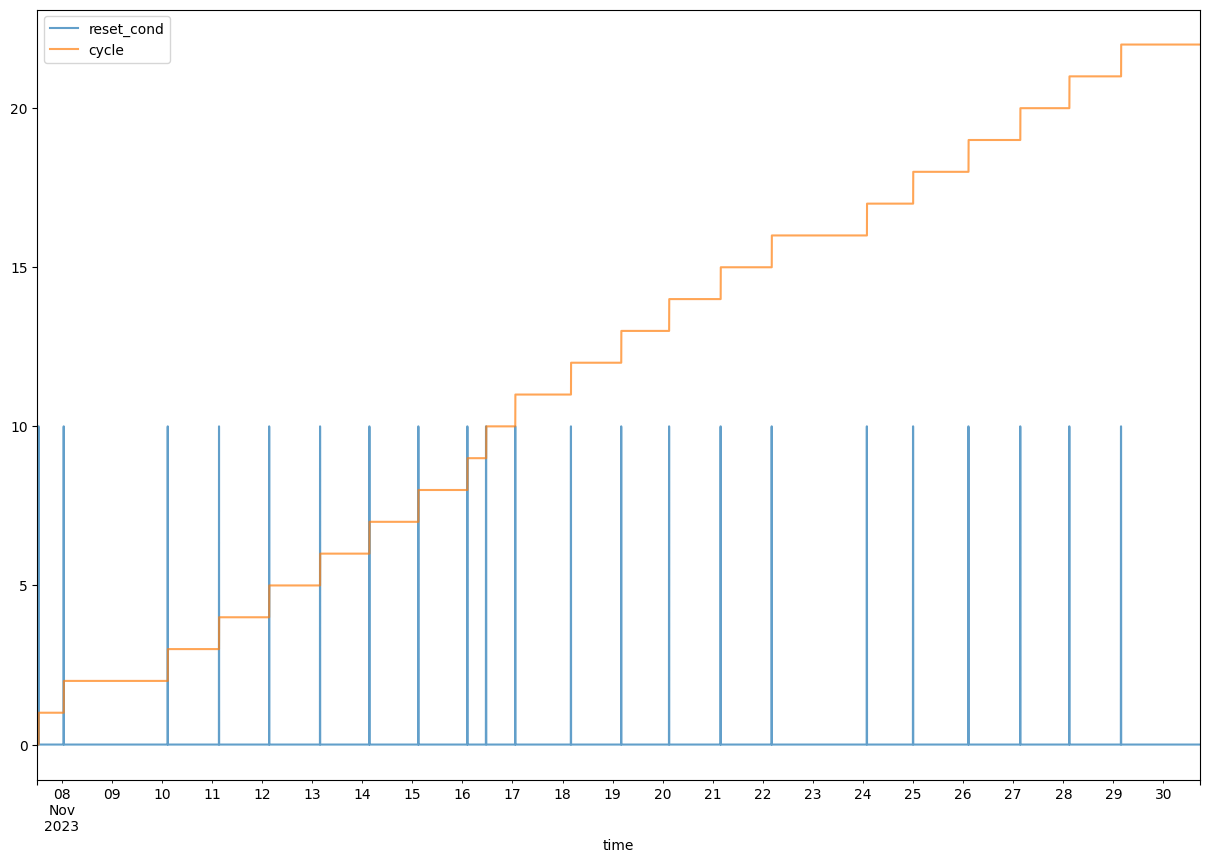

In [162]:
#ax1 = df.plot.line( y=['bms_average_cell_voltage'], alpha=0.8, figsize = (15, 10) )

df2 = df.copy()

df2['reset_cond'] = df2.bms_average_cell_voltage > 3.43
df2['reset_cond2'] = df2.bms_average_cell_voltage.rolling(5).mean() < 3.37
df2['reset_cond'] = df2.reset_cond.shift(100) & df2.reset_cond2
df2['reset_cond2'] = (df2.reset_cond.shift(1) == 1) & (df2.reset_cond == 0)
df2['cycle'] = df2.reset_cond2.cumsum().astype('int32')
df2['cycle_row'] = df2.groupby(['cycle']).cumcount()

df2['reset_cond'] = df2['reset_cond'].astype('float16') * 10
#df2['cycle'] = df2['cycle'].astype('float16')
#fig = px.line(df2[:10000], y=['bms_average_cell_voltage', 'reset_cond'], width=1200, height=600)
#fig.show()
ax1 = df2.plot.line( y=['reset_cond','cycle'], alpha=0.7, figsize = (15, 10) )

In [163]:
# drop non complete cycles
max_cycle = df2.cycle.max()
df2 = df2.loc[ (df2.cycle > 0) & (df2.cycle < max_cycle)]

In [164]:
# coulonometer error per cycle (overshoot/undershoot)
df2.groupby(['cycle'])['bms_current'].sum()/360  # 3600 / 10 sec

cycle
1    25.7364
2    74.6367
3    40.1124
4    44.9095
5    43.2829
6    44.5532
7    42.3145
8    39.5854
9     9.3926
10   28.5061
11   45.7310
12   44.1852
13   43.2119
14   44.5188
15   45.2416
16   85.3169
17   37.2051
18   43.7802
19   44.3565
20   41.9262
21   44.9052
Name: bms_current, dtype: float64

In [165]:
# Difference between energy in and energy out (A*h) for one cycle on average
avg_shift_k = (df2.groupby(['cycle'])['bms_current'].sum()/360).mean()
avg_shift_k

43.495647023809525

In [166]:
# coulombic efficiency of a lfp battery is about 0.99
coulombic_efficiency = 0.99

In [167]:
corr = df2.groupby(['cycle'])['bms_current'].agg([('discharge' , lambda x : x[x < 0].sum()) , ('charge' , lambda x : x[x > 0].sum())]) / 360
corr['k'] = -corr.charge * coulombic_efficiency / corr.discharge
corr.k.mean()

1.0872751906935172

In [168]:
corr

,discharge,charge,k
cycle,,,
1,-254.4879,280.2243,1.0901
2,-733.6864,808.3231,1.0907
3,-411.1234,451.2359,1.0866
4,-455.0306,499.9401,1.0877
5,-447.3130,490.5960,1.0858
6,-454.4383,498.9916,1.0871
7,-432.6954,475.0099,1.0868
8,-403.5639,443.1493,1.0871
9,-93.7963,103.1889,1.0891


In [169]:
discharge_sum = df2[df2.bms_current < 0].bms_current.sum()
charge_sum = df2[df2.bms_current > 0].bms_current.sum()
corr_k = charge_sum * coulombic_efficiency / -discharge_sum
corr_k

1.0870208977500797

In [170]:
def correct(x):
    if x < 0:
        return x * corr_k
    return x

df2.loc[:,'bms_current_corrected'] = df2['bms_current'].apply(correct).copy()
#df2['bms_current_corrected'] = df2['bms_current'].apply(correct)

In [171]:
# calculated SOC
max_capacity = 510.0
df2.loc[:,'calculated_soc'] = (( ( df2.groupby(['cycle'])['bms_current_corrected'].cumsum()/360) + max_capacity) / max_capacity) * 100.0
df2.loc[:,'calculated_soc'] = df2.calculated_soc.clip(0, 100.0)

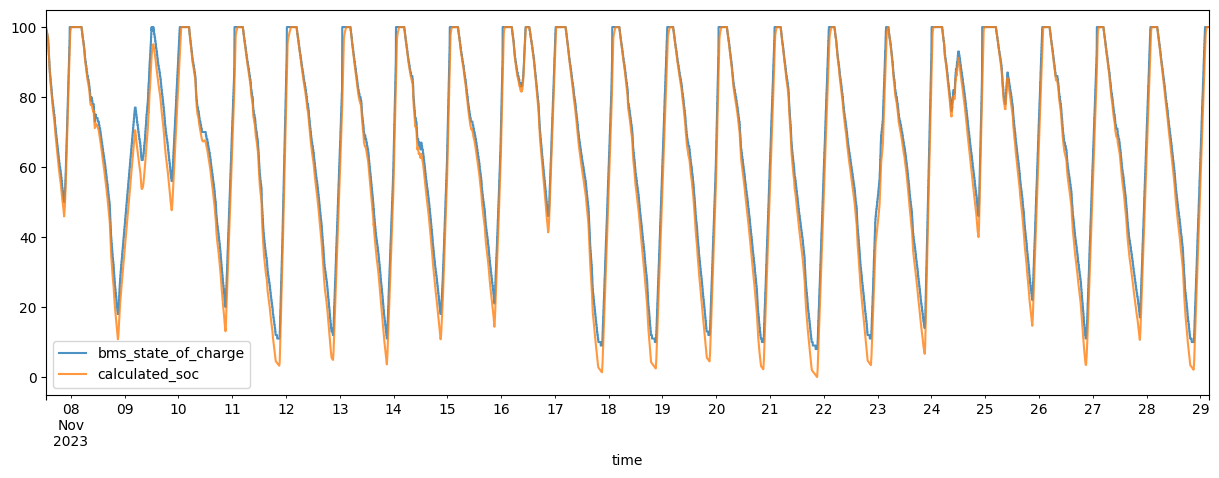

In [172]:
ax1 = df2.plot.line( y=['bms_state_of_charge', 'calculated_soc'], alpha=0.8, figsize = (15, 5) )
#ax1.axhline(0, c='r')

In [173]:
df2 = df2.drop(columns=['reset_cond', 'reset_cond2'])

In [174]:
# Select only trusted data (24h after SOC reset)
#cycles_row_max = 24 * 60 * 60 / 10
#df2 = df2.loc[df2.cycle_row < cycles_row_max]

In [175]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 186737 entries, 2023-11-07 12:58:10+00:00 to 2023-11-29 03:40:50+00:00
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   bms_state_of_charge       186736 non-null  float64
 1   bms_capacity_remaining    186736 non-null  float64
 2   bms_average_cell_voltage  186736 non-null  float64
 3   bms_delta_cell_voltage    186736 non-null  float64
 4   bms_current               186736 non-null  float64
 5   bms_temperature_2         186736 non-null  float64
 6   bms_cell_voltage_1        186736 non-null  float64
 7   bms_cell_voltage_2        186736 non-null  float64
 8   bms_cell_voltage_3        186736 non-null  float64
 9   bms_cell_voltage_4        186736 non-null  float64
 10  bms_cell_voltage_5        186736 non-null  float64
 11  bms_cell_voltage_6        186736 non-null  float64
 12  bms_cell_voltage_7        186736 non-null  float64
 13

In [176]:
# Is there something special about cell voltage difference ?

df2['cd'] = (df2.bms_average_cell_voltage - df2.bms_cell_voltage_4)

df2['cd2'] = abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_1) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_2) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_3) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_4) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_5) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_6) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_7) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_8)
df2['cd3'] = (df2.bms_average_cell_voltage - df2.bms_cell_voltage_7) # * (df2.bms_cell_voltage_7 - df2.bms_cell_voltage_4) * 10
#df['cd3'] =
#df['cd'] = df.current / df.cd
#df2 = df.copy()
#df2 = df2.resample('1min').mean()

In [177]:
def cord(r):
    cl = [ r['bms_cell_voltage_1'], r['bms_cell_voltage_2'], r['bms_cell_voltage_3'], \
          r['bms_cell_voltage_4'], r['bms_cell_voltage_5'], r['bms_cell_voltage_6'], \
          r['bms_cell_voltage_7'], r['bms_cell_voltage_8'],]
    sorted_cl = [i[0] for i in sorted(enumerate(cl), key=lambda x:x[1])]
    return int(''.join(str(item) for item in sorted_cl))

df2['cord'] = df2.apply(cord, axis=1)
df2.head()

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,cycle,cycle_row,bms_current_corrected,calculated_soc,cd,cd2,cd3,cord
time,,,,,,,,,,,,,,,,,,,,,,
2023-11-07 12:58:10+00:00,99.0000,507.2280,3.3280,0.0060,-10.9560,23.9600,3.3278,3.3276,3.3306,3.3270,3.3292,3.3246,3.3276,3.3292,1,0,-11.9094,99.9935,0.0010,0.0103,0.0004,53160472
2023-11-07 12:58:20+00:00,99.0000,507.2000,3.3275,0.0058,-11.2840,23.9400,3.3270,3.3264,3.3304,3.3268,3.3288,3.3248,3.3274,3.3282,1,1,-12.2659,99.9868,0.0007,0.0100,0.0001,51306742
2023-11-07 12:58:30+00:00,99.0000,507.1700,3.3272,0.0058,-9.2240,24.0000,3.3276,3.3262,3.3298,3.3264,3.3288,3.3242,3.3270,3.3274,1,2,-10.0267,99.9814,0.0008,0.0098,0.0002,51367042
2023-11-07 12:58:40+00:00,99.0000,507.1400,3.3278,0.0054,-10.1260,23.9400,3.3278,3.3272,3.3302,3.3276,3.3290,3.3250,3.3272,3.3286,1,3,-11.0072,99.9754,0.0002,0.0086,0.0006,51630742
2023-11-07 12:58:50+00:00,99.0000,507.1140,3.3261,0.0050,-6.2900,23.9200,3.3264,3.3254,3.3276,3.3248,3.3272,3.3234,3.3262,3.3276,1,4,-6.8374,99.9717,0.0013,0.0092,-0.0001,53160472


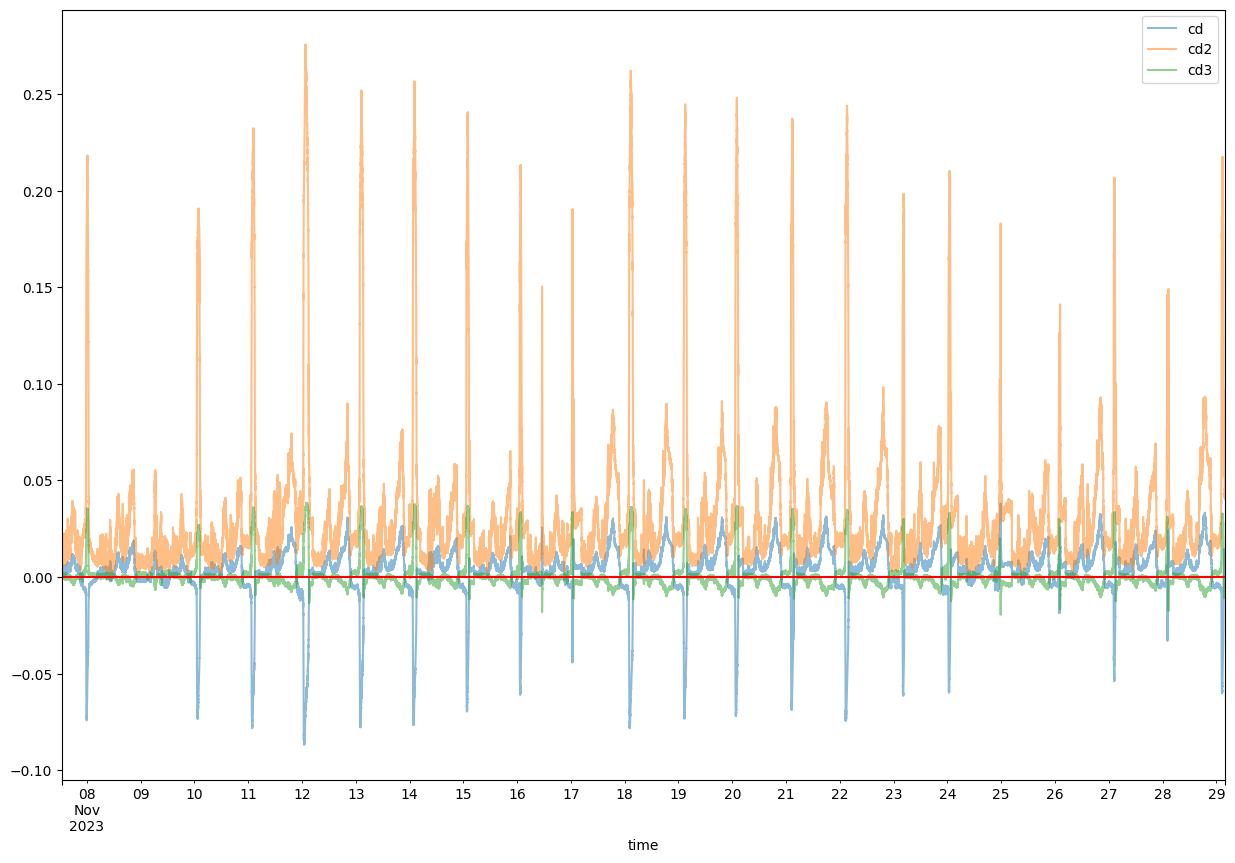

In [178]:
ax1 = df2.plot.line( y=['cd', 'cd2', 'cd3'], alpha=0.5, figsize = (15, 10) )
ax1.axhline(0, c='r')

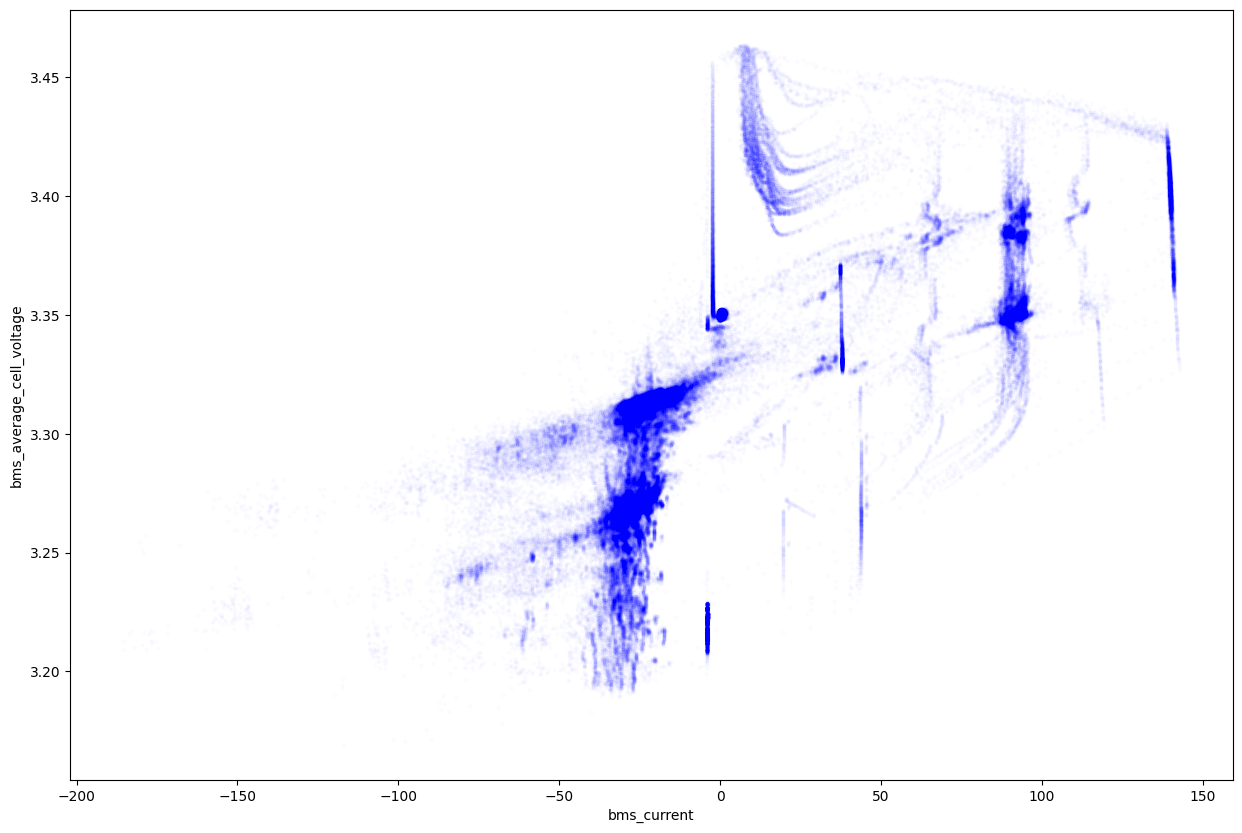

In [179]:
# relationship between current and battery cell voltages

ax1 = df2.plot.scatter(x='bms_current',
                      y='bms_average_cell_voltage',
                      c='Blue', alpha=0.01, marker='.', figsize = (15, 10) )

In [180]:
df3 = df.copy()
df3['volt_diff'] = df2.bms_average_cell_voltage.diff()
df3['current_diff'] = df2.bms_current.diff()

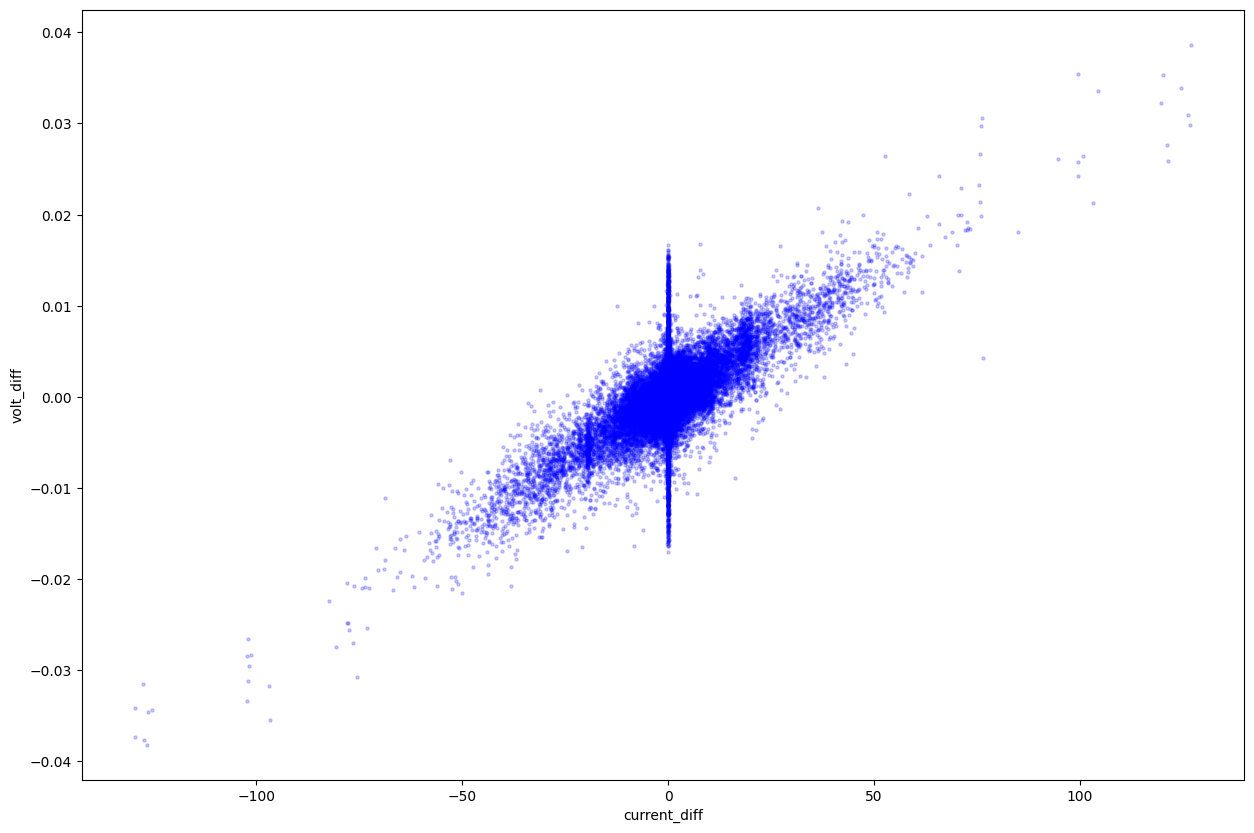

In [181]:
ax1 = df3.plot.scatter(x='current_diff',
                      y='volt_diff',
                      c='Blue', alpha=0.2, marker='.', figsize = (15, 10) )

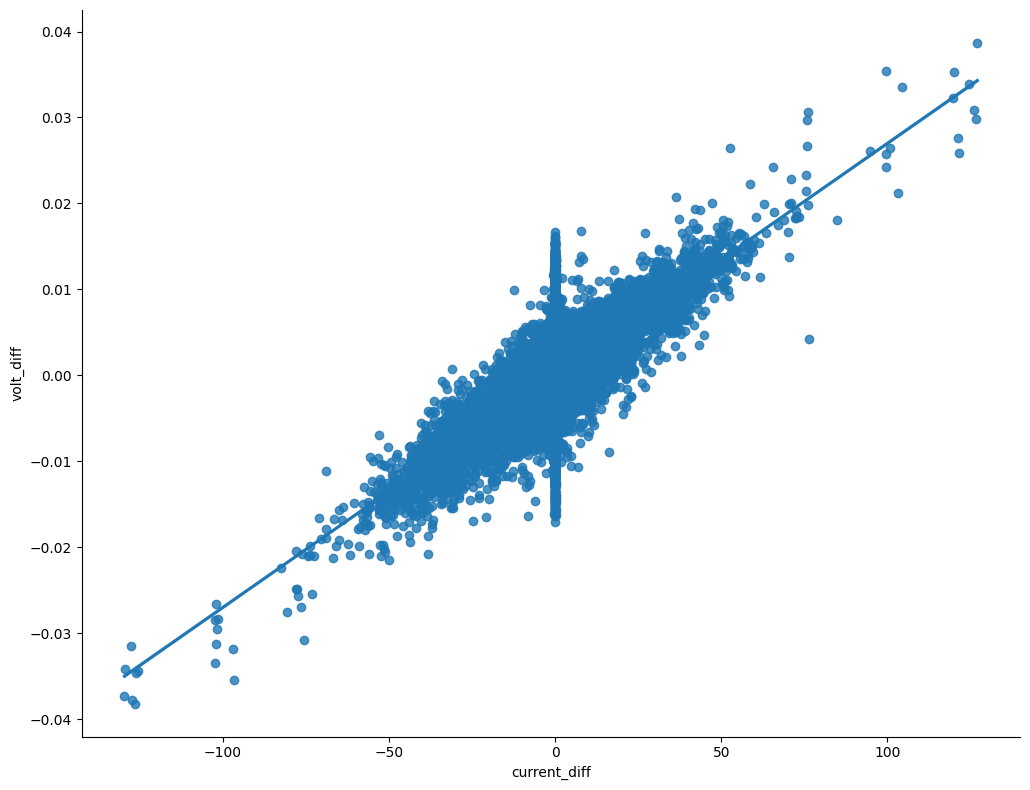

In [182]:
import seaborn as sns
#from matplotlib import pyplot as plt
#plt.figure(figsize=(15,8))
sns.lmplot(x='current_diff',y='volt_diff',data=df3,fit_reg=True, height=8, aspect=1.3)

In [183]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [184]:
df3 = df3.dropna()
X = df3.current_diff.values.reshape(-1,1)
y = df3.volt_diff.values.reshape(-1,1)
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.4627582050076302

In [185]:
reg.coef_[0][0]

0.0002699411538382041

In [186]:
reg.intercept_[0]

1.330512839575318e-07

In [187]:
# what if will take average deviation for a 5-10 min of voltage and current ?

In [222]:
df['cv_corr'] = df.bms_average_cell_voltage - df.bms_current * reg.coef_[0][0] * 2 + reg.intercept_[0]
df2['cv_corr'] = df2.bms_average_cell_voltage - df2.bms_current * reg.coef_[0][0] * 1 + reg.intercept_[0]

In [223]:
df2.head()

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,cycle,...,cv_corr,soc_d,cur_d,volt_d,v_c,volt_diff,roll_v_10,roll_c_10,roll_cs_90,roll_v_90,roll_c_90,temp_roll_90,roll_d_10,roll_d_25,d_trend
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-07 13:13:10+00:00,99.0000,503.3060,3.3145,0.0042,-18.2420,23.8000,3.3158,3.3144,3.3160,3.3128,3.3152,3.3124,3.3136,3.3158,1,...,3.3194,99.9935,-10.9560,3.3280,3.3327,0.0013,3.3131,-23.0148,-1426.3260,3.3193,-15.8481,23.8564,0.0002,0.0002,0.0002
2023-11-07 13:13:20+00:00,99.0000,503.2500,3.3148,0.0044,-17.1720,23.8000,3.3158,3.3156,3.3164,3.3136,3.3156,3.3130,3.3132,3.3154,1,...,3.3195,99.9868,-11.2840,3.3275,3.3320,0.0003,3.3133,-22.1276,-1432.2140,3.3191,-15.9135,23.8549,0.0002,0.0002,0.0002
2023-11-07 13:13:30+00:00,99.0000,503.2020,3.3148,0.0048,-17.2100,23.8000,3.3168,3.3150,3.3164,3.3132,3.3154,3.3128,3.3134,3.3156,1,...,3.3195,99.9814,-9.2240,3.3272,3.3320,-0.0000,3.3135,-21.1782,-1440.2000,3.3190,-16.0022,23.8527,0.0003,0.0001,0.0003
2023-11-07 13:13:40+00:00,99.0000,503.1600,3.3143,0.0040,-17.3360,23.8000,3.3154,3.3138,3.3156,3.3126,3.3148,3.3132,3.3136,3.3158,1,...,3.3190,99.9754,-10.1260,3.3278,3.3317,-0.0005,3.3137,-20.6662,-1447.4100,3.3188,-16.0823,23.8511,0.0002,0.0001,0.0002
2023-11-07 13:13:50+00:00,99.0000,503.1100,3.3153,0.0042,-19.0260,23.8000,3.3168,3.3158,3.3168,3.3132,3.3158,3.3138,3.3142,3.3160,1,...,3.3205,99.9717,-6.2900,3.3261,3.3343,0.0010,3.3140,-20.2866,-1460.1460,3.3187,-16.2238,23.8498,0.0002,0.0001,0.0002


In [225]:
#fig = px.line(df2, y=["cv_corr","bms_average_cell_voltage"], width=1200, height=600)
#fig.show()

# Modeling

In [191]:
df2.head()

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,cycle,cycle_row,bms_current_corrected,calculated_soc,cd,cd2,cd3,cord,cv_corr
time,,,,,,,,,,,,,,,,,,,,,,,
2023-11-07 12:58:10+00:00,99.0000,507.2280,3.3280,0.0060,-10.9560,23.9600,3.3278,3.3276,3.3306,3.3270,3.3292,3.3246,3.3276,3.3292,1,0,-11.9094,99.9935,0.0010,0.0103,0.0004,53160472,3.3339
2023-11-07 12:58:20+00:00,99.0000,507.2000,3.3275,0.0058,-11.2840,23.9400,3.3270,3.3264,3.3304,3.3268,3.3288,3.3248,3.3274,3.3282,1,1,-12.2659,99.9868,0.0007,0.0100,0.0001,51306742,3.3336
2023-11-07 12:58:30+00:00,99.0000,507.1700,3.3272,0.0058,-9.2240,24.0000,3.3276,3.3262,3.3298,3.3264,3.3288,3.3242,3.3270,3.3274,1,2,-10.0267,99.9814,0.0008,0.0098,0.0002,51367042,3.3321
2023-11-07 12:58:40+00:00,99.0000,507.1400,3.3278,0.0054,-10.1260,23.9400,3.3278,3.3272,3.3302,3.3276,3.3290,3.3250,3.3272,3.3286,1,3,-11.0072,99.9754,0.0002,0.0086,0.0006,51630742,3.3333
2023-11-07 12:58:50+00:00,99.0000,507.1140,3.3261,0.0050,-6.2900,23.9200,3.3264,3.3254,3.3276,3.3248,3.3272,3.3234,3.3262,3.3276,1,4,-6.8374,99.9717,0.0013,0.0092,-0.0001,53160472,3.3295


In [192]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
bms_state_of_charge,186736.0000,65.5171,27.6299,8.0000,44.0000,69.0000,90.0000,100.0000
bms_capacity_remaining,186736.0000,334.0642,140.8065,40.5120,224.0145,353.5540,460.1261,510.0000
bms_average_cell_voltage,186736.0000,3.3120,0.0541,3.1693,3.2701,3.3121,3.3499,3.4636
bms_delta_cell_voltage,186736.0000,0.0148,0.0170,0.0012,0.0060,0.0096,0.0160,0.1116
bms_current,186736.0000,1.7609,49.9652,-185.6200,-27.8200,-20.6400,10.7640,142.8620
bms_temperature_2,186736.0000,24.2248,2.4746,19.4800,22.4800,23.8000,25.5800,33.4000
bms_cell_voltage_1,186736.0000,3.3133,0.0531,3.1758,3.2716,3.3134,3.3490,3.4794
bms_cell_voltage_2,186736.0000,3.3114,0.0600,3.1552,3.2690,3.3118,3.3480,3.4768
bms_cell_voltage_3,186736.0000,3.3131,0.0515,3.1770,3.2716,3.3136,3.3530,3.4788
bms_cell_voltage_4,186736.0000,3.3096,0.0647,3.1384,3.2656,3.3094,3.3466,3.4906


In [193]:
df2['soc_d'] = df2.calculated_soc.shift(90)
df2['cur_d'] = df2.bms_current.shift(90)
df2['volt_d'] = df2.bms_average_cell_voltage.shift(90)

In [194]:
df2['v_c'] = df2.bms_average_cell_voltage - df2.bms_current * 0.001

In [195]:
df2['volt_diff'] = df2.bms_average_cell_voltage.diff()

In [196]:
df2['roll_v_10'] = df2.bms_average_cell_voltage.rolling(10).mean()
df2['roll_c_10'] = df2.bms_current.rolling(10).mean()

# interesting observation here
# decision tree model fails to learn a + b = c
# this is natural since it partitioning the data
# the neural network in this case would be able to learn that relationship
# since we have direct solution with the following feature
df2['roll_cs_90'] = df2.bms_current.rolling(90).sum()

#df2['roll_vs_90'] = df2.bms_average_cell_voltage.rolling(90).sum()
df2['roll_v_90'] = df2.bms_average_cell_voltage.rolling(90).mean()
df2['roll_c_90'] = df2.bms_current.rolling(90).mean()
#df2['v_trend'] = df2.roll_v_10 / (df2.roll_v_25 + 1)
df2['temp_roll_90'] = df2.bms_temperature_2.rolling(90).mean()

In [197]:
df2['roll_d_10'] = df2.volt_diff.rolling(10).mean()
df2['roll_d_25'] = df2.volt_diff.rolling(25).mean()
df2['d_trend'] = df2.roll_d_10 / (df2.roll_d_25 + 1 )

In [198]:
#df2['t2_trend'] = df2.bms_temperature_2.rolling(10).mean() / (df2.bms_temperature_2.rolling(25).mean() + 1 )

In [199]:
df2 = df2.dropna()

In [200]:
# Select only trusted data (24h after SOC reset)
cycles_row_max = 24 * 60 * 60 / 10
df2 = df2.loc[df2.cycle_row < cycles_row_max]

In [201]:
df2.head(10)

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,cycle,...,cv_corr,soc_d,cur_d,volt_d,v_c,volt_diff,roll_v_10,roll_c_10,roll_cs_90,roll_v_90,roll_c_90,temp_roll_90,roll_d_10,roll_d_25,d_trend
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-07 13:13:10+00:00,99.0000,503.3060,3.3145,0.0042,-18.2420,23.8000,3.3158,3.3144,3.3160,3.3128,3.3152,3.3124,3.3136,3.3158,1,...,3.3243,99.9935,-10.9560,3.3280,3.3327,0.0013,3.3131,-23.0148,-1426.3260,3.3193,-15.8481,23.8564,0.0002,0.0002,0.0002
2023-11-07 13:13:20+00:00,99.0000,503.2500,3.3148,0.0044,-17.1720,23.8000,3.3158,3.3156,3.3164,3.3136,3.3156,3.3130,3.3132,3.3154,1,...,3.3241,99.9868,-11.2840,3.3275,3.3320,0.0003,3.3133,-22.1276,-1432.2140,3.3191,-15.9135,23.8549,0.0002,0.0002,0.0002
2023-11-07 13:13:30+00:00,99.0000,503.2020,3.3148,0.0048,-17.2100,23.8000,3.3168,3.3150,3.3164,3.3132,3.3154,3.3128,3.3134,3.3156,1,...,3.3241,99.9814,-9.2240,3.3272,3.3320,-0.0000,3.3135,-21.1782,-1440.2000,3.3190,-16.0022,23.8527,0.0003,0.0001,0.0003
2023-11-07 13:13:40+00:00,99.0000,503.1600,3.3143,0.0040,-17.3360,23.8000,3.3154,3.3138,3.3156,3.3126,3.3148,3.3132,3.3136,3.3158,1,...,3.3237,99.9754,-10.1260,3.3278,3.3317,-0.0005,3.3137,-20.6662,-1447.4100,3.3188,-16.0823,23.8511,0.0002,0.0001,0.0002
2023-11-07 13:13:50+00:00,99.0000,503.1100,3.3153,0.0042,-19.0260,23.8000,3.3168,3.3158,3.3168,3.3132,3.3158,3.3138,3.3142,3.3160,1,...,3.3256,99.9717,-6.2900,3.3261,3.3343,0.0010,3.3140,-20.2866,-1460.1460,3.3187,-16.2238,23.8498,0.0002,0.0001,0.0002
2023-11-07 13:14:00+00:00,99.0000,503.0560,3.3139,0.0048,-21.7920,23.8000,3.3162,3.3140,3.3150,3.3118,3.3146,3.3122,3.3128,3.3148,1,...,3.3257,99.9624,-15.5680,3.3254,3.3357,-0.0014,3.3140,-20.2246,-1466.3700,3.3186,-16.2930,23.8480,0.0001,0.0000,0.0001
2023-11-07 13:14:10+00:00,99.0000,502.9980,3.3140,0.0042,-20.8460,23.8000,3.3148,3.3144,3.3148,3.3118,3.3152,3.3126,3.3126,3.3158,1,...,3.3253,99.9577,-7.9860,3.3270,3.3349,0.0001,3.3142,-19.9770,-1479.2300,3.3184,-16.4359,23.8464,0.0002,-0.0000,0.0002
2023-11-07 13:14:20+00:00,99.0000,502.9400,3.3150,0.0046,-19.3160,23.8000,3.3170,3.3154,3.3166,3.3132,3.3154,3.3132,3.3132,3.3158,1,...,3.3254,99.9486,-15.3240,3.3230,3.3343,0.0010,3.3143,-19.6550,-1483.2220,3.3184,-16.4802,23.8449,0.0001,0.0000,0.0001
2023-11-07 13:14:30+00:00,99.0000,502.8820,3.3157,0.0040,-16.9620,23.8000,3.3166,3.3160,3.3174,3.3138,3.3168,3.3140,3.3146,3.3160,1,...,3.3248,99.9388,-16.6020,3.3260,3.3326,0.0007,3.3146,-19.0562,-1483.5820,3.3182,-16.4842,23.8429,0.0002,0.0001,0.0002


In [202]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [203]:
model = xgb.XGBRegressor(n_estimators=250, max_depth=10, eta=0.3, subsample=0.7, colsample_bytree=0.8)

In [204]:
X = df2[[
        'bms_current',
#         'v_c',
         'bms_average_cell_voltage',
         'soc_d',
#         'bms_delta_cell_voltage',
#         'cord',
#         'cd',
#         'cd2',
#         'cd3',
#        'v_trend', 'd_trend',
#         'cur_d',
#         'volt_d',
         'roll_c_10',
         'roll_c_90',
         'roll_v_10',
         'roll_v_90',
         'roll_cs_90',
#         'roll_vs_90',
         'bms_temperature_2',
         'temp_roll_90'
]]

#y = df2['bms_state_of_charge']
y = df2['calculated_soc']

In [205]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [206]:
train_X.shape

(116342, 10)

In [207]:
model.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, ...)

In [208]:
# Predict the model
pred = model.predict(test_X)
pred = pred.clip(0, 100.0)

In [209]:
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

RMSE :  0.119804


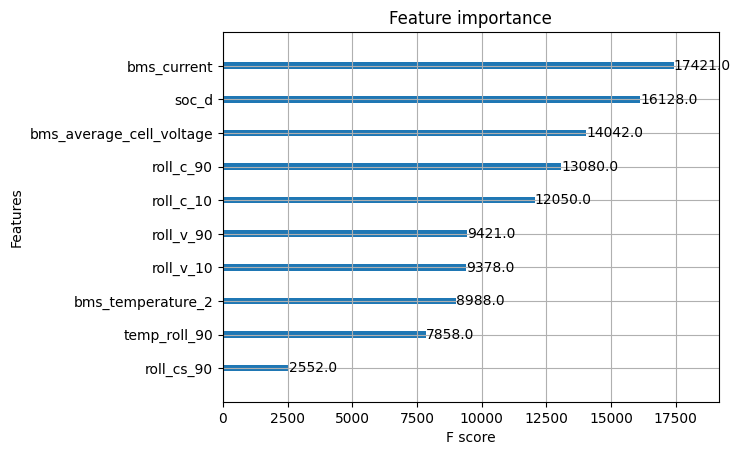

In [210]:
xgb.plot_importance(model)
plt.show()

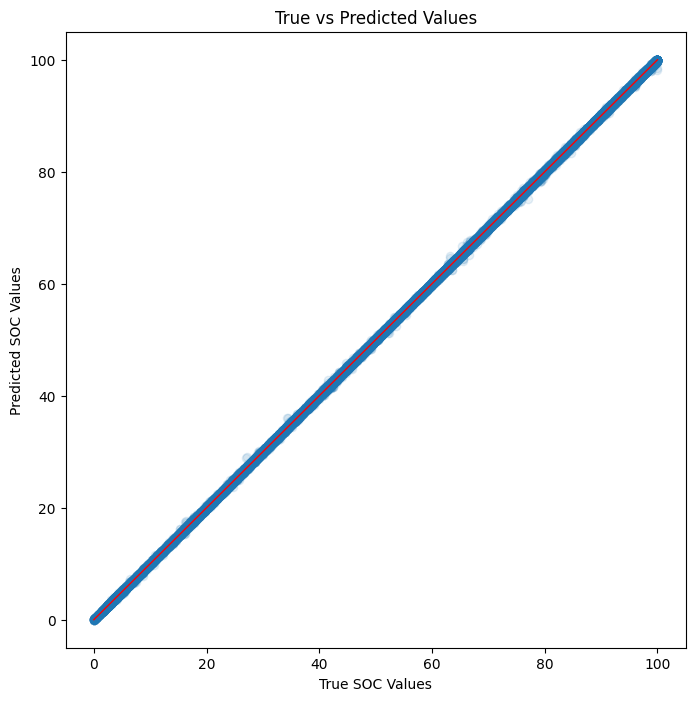

In [211]:
plt.figure(figsize=(8, 8))
plt.scatter(test_y, pred, alpha = 0.1)
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], color='red', linewidth=1)
plt.xlabel('True SOC Values')
plt.ylabel('Predicted SOC Values')
plt.title('True vs Predicted Values')
plt.show()

In [212]:
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

RMSE :  0.119804


# Error analysis

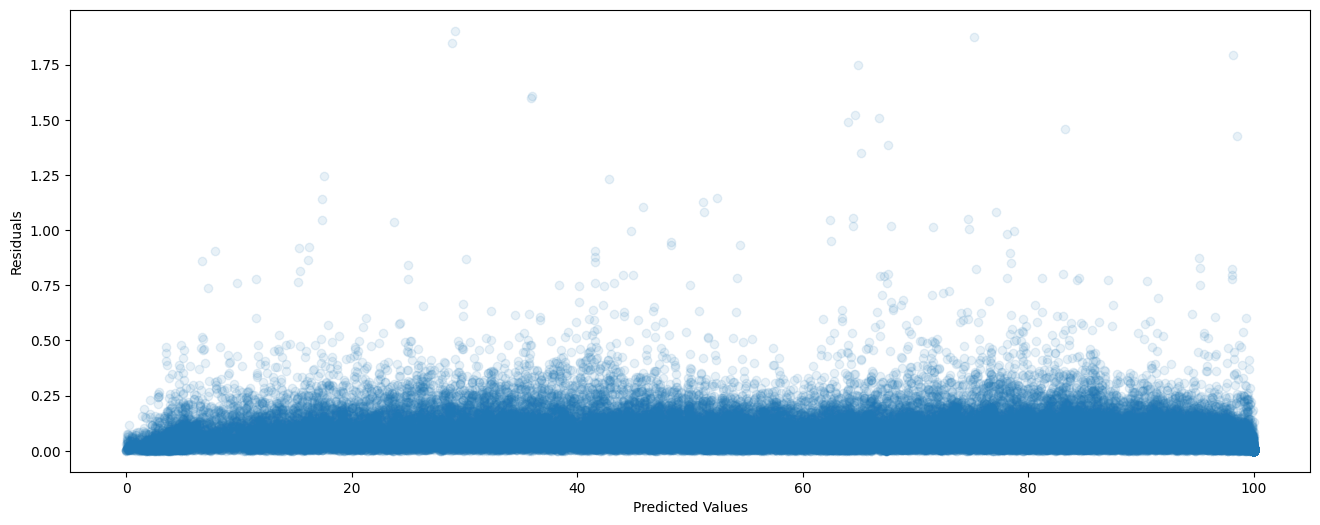

In [213]:
residuals_abs = abs(test_y - pred)
plt.figure(figsize=(16, 6))
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.scatter(pred, residuals_abs, alpha = 0.1)

In [214]:
rdf = pd.DataFrame({'test_y': test_y, 'pred': pred, 'res': residuals_abs})

<Axes: xlabel='bin', ylabel='Residuals mean'>

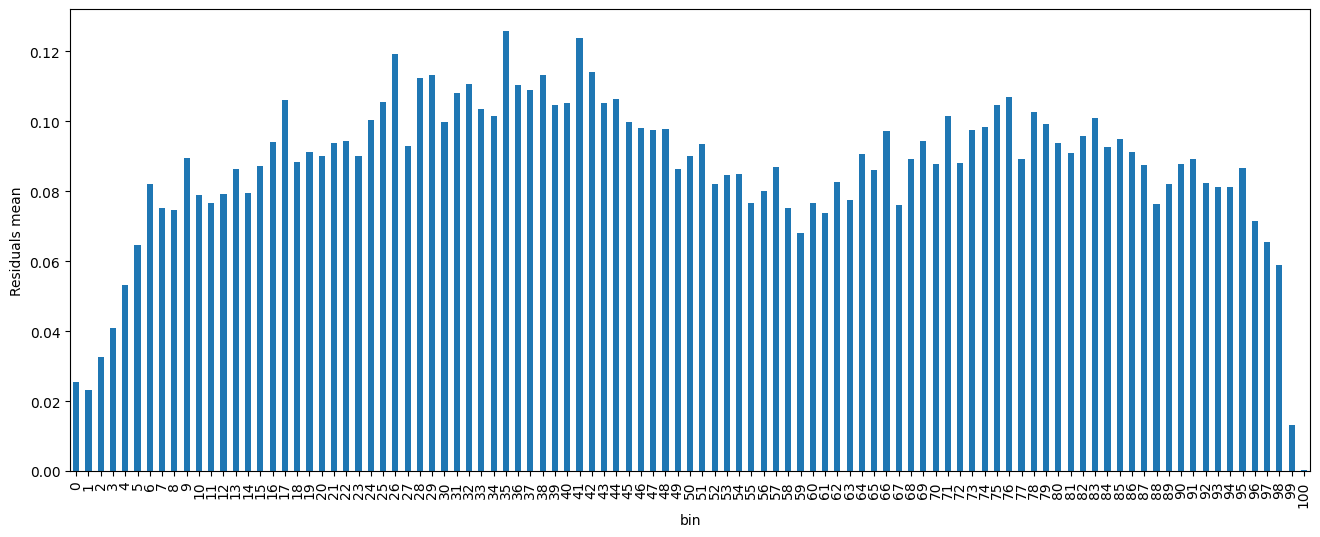

In [215]:
rdf['bin'] = (rdf.pred / 1).astype('int32')

plt.figure(figsize=(16, 6))
plt.xlabel('Predicted Values (buckets)')
plt.ylabel('Residuals mean')
(rdf.groupby('bin')['res'].mean()).plot(kind='bar')

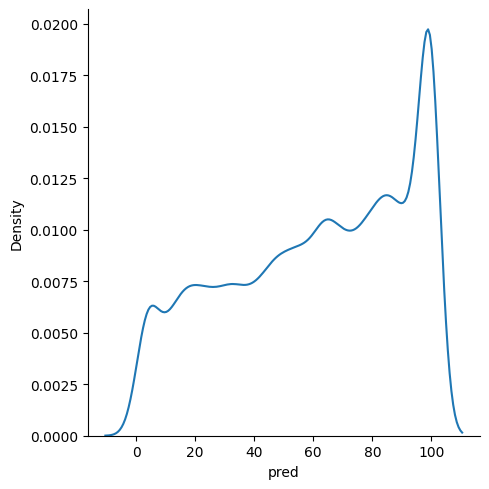

In [216]:
sns.displot(data=rdf, x="pred", kind="kde")

In [217]:
# target value deviation distribution from soc_d
div = df2.calculated_soc  - df2.soc_d
div = div.clip(-10,10)

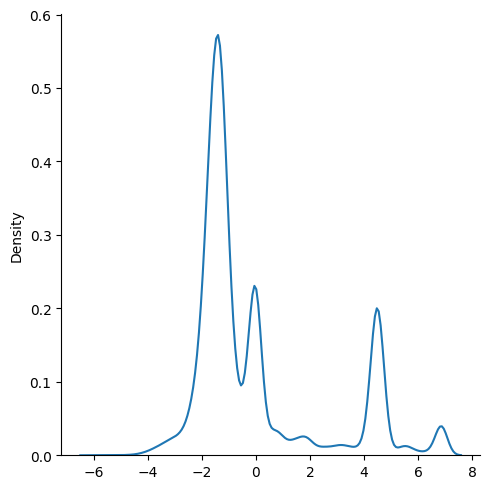

In [218]:
sns.displot(data=div, kind="kde")